# Slide Rule example

From the [SlideRule documentation](http://icesat2sliderule.org/rtd/), "SlideRule is a web service for on-demand science data processing, which provides researchers and other Earth science data systems low-latency access to customized data products using processing parameters supplied at the time of the request. SlideRule runs in AWS us-west-2 and has access to the official ICESat-2 datasets hosted by the NSIDC." See the documentation for installation instructions.

## Step 1: Install packages

In [1]:
import matplotlib.pyplot as plt
from sliderule import icesat2
from ipyleaflet import Map, GeoData, LayersControl,Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon

Import the functions from our `coastal` library. The library is at `../` so we need to append that to the Python path.

In [2]:
import sys
sys.path.append('../')
from coastal.beam import reduce_dataframe
from coastal.plot import plot_atl08, plot_yapc

## Step 2: Initialize the icesat2 package

In [3]:
icesat2.init("icesat2sliderule.org", verbose=True)

## Step 3: Create a list of coordinates

Here we will import a geojson file that represents the White Mountain, Alaska region of interest. Our geojson file looks like so

```
{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-163.16619873046875,64.4064312702572],[-162.75421142578125,64.34823209154665],[-162.77893066406247,64.54607936653424],[-163.3062744140625,64.79518717004242],[-163.69903564453122,64.69910544204765],[-163.16619873046875,64.4064312702572]]]}}]}
```

We have this saved to a file `whitemountain.geojson`.

In [4]:
# import the map.geojson file representing the ROI
spatialExtent = icesat2.toregion('data/whitemountain.geojson')["poly"]

In [5]:
# check the format of the coordinates
spatialExtent

[{'lon': -162.75421142578125, 'lat': 64.34823209154665},
 {'lon': -162.77893066406247, 'lat': 64.54607936653424},
 {'lon': -163.3062744140625, 'lat': 64.79518717004242},
 {'lon': -163.69903564453122, 'lat': 64.69910544204765},
 {'lon': -163.16619873046875, 'lat': 64.4064312702572},
 {'lon': -162.75421142578125, 'lat': 64.34823209154665}]

In [6]:
# create bounding box
bb = [spatialExtent[0]['lon'], spatialExtent[0]['lat'], 
      spatialExtent[2]['lon'], spatialExtent[2]['lat']]

# create polygon for plotting
polygon = Polygon(
    locations=spatialExtent,
    color="green"
)

## Step 4: Visualize region of interest

In [7]:
center = [spatialExtent[0]['lat'], spatialExtent[0]['lon']]
zoom = 8
m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
m.add_layer(polygon);
m

Map(center=[64.34823209154665, -162.75421142578125], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Step 5: Create a dictionary of processing parameters

These will specify how the elevations (from ATL03 photon data) for the region should be calculated.

In [8]:
%%time

# build sliderule parameters for ATL03 subsetting request
# SRT_LAND = 0
# SRT_OCEAN = 1
# SRT_SEA_ICE = 2
# SRT_LAND_ICE = 3
# SRT_INLAND_WATER = 4
parms = {
    # processing parameters
    "srt": icesat2.SRT_LAND,
    "len": 20,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True, 
    # all photons
    "cnf": -2, 
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0), 
}

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.58 µs


Set the data asset, release and time boundaries for query

In [9]:
# Set ICESat-2 data asset
asset = "nsidc-s3"

# ICESat-2 data release
release = '005'

# time bounds for CMR query
time_start = '2019-07-10'
time_end = '2019-07-20'

## Step 6: Find the granules

This code will find the granules, create an empty geodataframe and write the query into the geodataframe.

In [10]:
# find granule for each region of interest
granules_list = icesat2.cmr(polygon=spatialExtent, time_start=time_start, time_end=time_end, version=release)

# create an empty geodataframe
parms["poly"] = spatialExtent

# write output into geodataframe
gdf = icesat2.atl03sp(parms, asset=asset, version=release, resources=granules_list)

INFO:sliderule.icesat2:Allocating 21 workers across 7 processing nodes
INFO:sliderule.icesat2:0 points returned for ATL03_20190710014600_01830405_005_01.h5 (1 out of 3 resources)
INFO:sliderule.icesat2:1361414 points returned for ATL03_20190714013741_02440405_005_01.h5 (2 out of 3 resources)
INFO:sliderule.icesat2:874960 points returned for ATL03_20190718012923_03050405_005_01.h5 (3 out of 3 resources)


In [11]:
# look at the resulting geodataframe
gdf.head()

,segment_id,segment_dist,track,cycle,rgt,sc_orient,delta_time,atl03_cnf,height,distance,atl08_class,yapc_score,quality_ph,pair,geometry
time,,,,,,,,,,,,,,,
2019-07-14 01:41:43.864015240,642346,1.286611e+07,3,4,244,0,4.830370e+07,0,167.423950,-8.519688,4,0,0,0,POINT (-162.95389 64.62952)
2019-07-14 01:41:43.864015240,642346,1.286611e+07,3,4,244,0,4.830370e+07,0,-0.217391,-3.846664,4,0,0,0,POINT (-162.95390 64.62948)
2019-07-14 01:41:43.864015240,642346,1.286611e+07,3,4,244,0,4.830370e+07,0,-187.967499,1.387081,4,0,0,0,POINT (-162.95392 64.62943)
2019-07-14 01:41:43.864015240,642346,1.286611e+07,3,4,244,0,4.830370e+07,0,-216.398285,2.179764,4,0,0,0,POINT (-162.95393 64.62943)
2019-07-14 01:41:43.864015240,642346,1.286611e+07,3,4,244,0,4.830370e+07,0,-271.506531,3.715942,4,24,0,0,POINT (-162.95393 64.62941)


## Step 7: Plot the Reference Ground Tracks 

The RGT is an imaginary line through the six-beam pattern that is handy for getting a sense of where the orbits fall on Earth, and which the mission uses to point the observatory.
For more information see the ICESat-2 description [here]("https://icesat-2.gsfc.nasa.gov/science/specs").

In [12]:
# get unique RGTs
rgtValues = gdf['rgt'].unique()
rgtValues.sort()
print(rgtValues)

[244 305]


Plot the output by RGT track within the region of interest

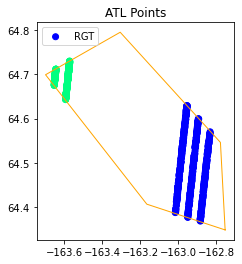

In [13]:
f, ax = plt.subplots()
ax.set_title("ATL Points")
ax.set_aspect('equal')
# FIX THIS TO SHOW EACH RGT value by color
gdf2 = gdf.sample(n=1000, replace=False, random_state=1)
gdf2.plot(ax=ax, column='rgt', label='RGT', c=gdf2['rgt'], cmap='winter')
ax.legend(loc="upper left")
# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in spatialExtent]
region_lat = [e["lat"] for e in spatialExtent]
ax.plot(region_lon, region_lat, linewidth=1, color='orange');

In [14]:
center = [spatialExtent[0]['lat'], spatialExtent[0]['lon']]
zoom = 8
m2 = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
m2.add_layer(polygon);
geo_data = GeoData(geo_dataframe = gdf.sample(n=1000, replace=False, random_state=1),
    style={'color': 'red', 'radius':1},
    point_style={'radius': 1, 'color': 'red', 'fillOpacity': 0.8},
    name = 'rgt')
m2.add_layer(geo_data)

In [15]:
m2

Map(center=[64.34823209154665, -162.75421142578125], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Step 9: Reduce GeoDataFrame to plot a single beam

We also want to convert coordinate reference system to compound projection. First let's see what is in our data.

In [16]:
df = gdf[['cycle', 'track', 'pair', 'sc_orient']]
for cyl in gdf['cycle'].unique():
  tmp = gdf[gdf['cycle']==cyl];
  for track in tmp['track'].unique():
    tmp2 = tmp[tmp['track']==track];    
    for rgt in tmp2['rgt'].unique():
       print('cycle=', cyl, ', track=', track, ', rgt=', rgt)

cycle= 4 , track= 3 , rgt= 244
cycle= 4 , track= 2 , rgt= 244
cycle= 4 , track= 2 , rgt= 305
cycle= 4 , track= 1 , rgt= 244
cycle= 4 , track= 1 , rgt= 305


We need to pick one of these.

In [17]:
beam_type = 'strong'
project_srs = "EPSG:26912+EPSG:5703"
D3 = reduce_dataframe(gdf, cycle=4, rgt=305, track=2, beam='strong', crs=project_srs)

In [18]:
D3["atl08_class"].value_counts()

4    150263
0        41
Name: atl08_class, dtype: int64

Class 4 is unclassified. It looks like our data are unclassified (4) or noise (0).

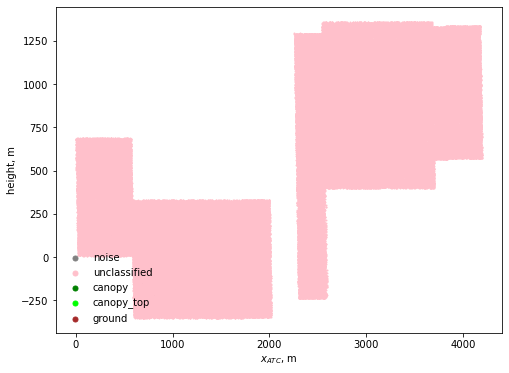

In [19]:
plot_atl08(D3);

Plot YAPC

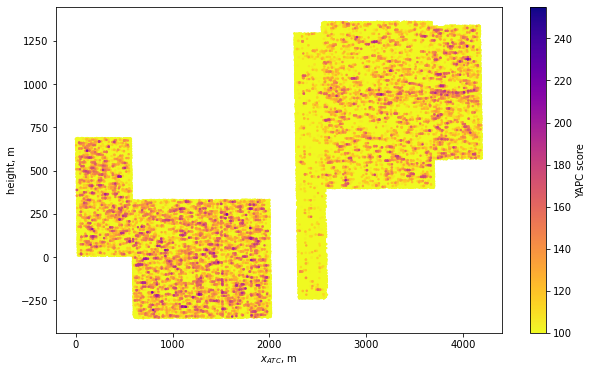

In [20]:
plot_yapc(D3);

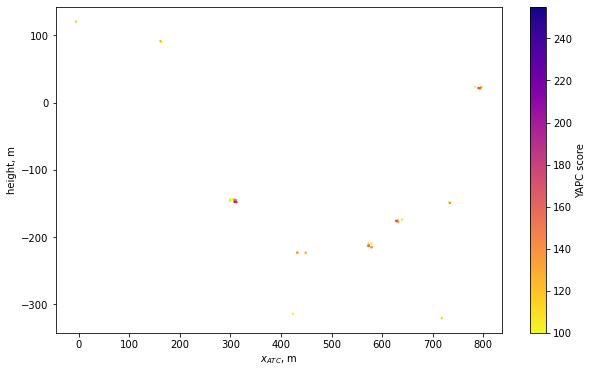

In [21]:
plot_yapc(D3[D3["atl08_class"] != 4]);